# Solving Incomplete Information General Equilibrium Models in Sequence Space
*Kwok Yan Chiu*

This notebook demonstrates an efficient method to solve dynamic incomplete information general equilibrium model. The details are in the companion note.

## Model
- Loglinearized consumption function with uncertain real interest rate and income
$$
    c_{i,t} = - \beta \sum_{k=0}^\infty \beta^k E_{i,t} [\xi_{t+k}] + (1 - \beta) \sum_{k=0}^\infty \beta^k E_{i,t} [y_{t+k}] \tag{1}
$$
- The income is demand-determined
$$
    y_t = \int_{0}^1 c_{i,t} di = -  \beta \sum_{k=0}^\infty \beta^k \bar{E}_{t} [\xi_{t+k}] + (1 - \beta) \sum_{k=0}^\infty \beta^k \bar{E}_{i,t} [y_{t+k}] \tag{2}
$$
- **Fundamental** $\xi_{t}$ is an exogenously given AR(1) process
$$
    \xi_t = \rho \xi_{t-1} + \epsilon_{t} \quad \text{with} \quad \epsilon_{t} \sim N(0, (\tau_\epsilon)^{-1})
$$
- **Info** agents forecast with model and signal sequence, $\{s_{i,t-s} \}_{s=0}^\infty$, where $s_{i,t}$ is given by
$$
    s_{i,t} = \xi_t + \eta_{i,t}  \quad \text{with} \quad \epsilon_i \sim N(0, (\tau_{\eta})^{-1})
$$

In [1]:
using Parameters, NLsolve, Polynomials, Plots, LinearAlgebra

### Analytical Solution
The analytical solution comes from Angeletos and Huo (2021).

$$
    y_t = \frac{\Delta}{(1 - \theta L)} \frac{b^*}{(1 - \rho L)} \epsilon_t
$$

where $\frac{b^*}{(1 - \rho L)} \epsilon_t$ is the output in the full information case with $b^* = -\frac{1}{1 - \rho}$.

$\theta$ and $\Delta$ are solution of some polynomial equation with both $\theta < 1$ and $\Delta < 1$


### Computational
The IRF of a one time shock in $\epsilon_{0}$ can be expressed as (see the note)

$$
\bm{h}(y) = 
-\beta
    \begin{bmatrix}
        m' \bm{M}^\epsilon_{0}
        \\
        m' \bm{M}^\epsilon_{1}
        \\
        m' \bm{M}^\epsilon_{2}
        \\
        \vdots
    \end{bmatrix}
    \bm{h}(\xi)
    +
    (1 - \beta)
    \begin{bmatrix}
        m' \bm{M}^\epsilon_{0}
        \\
        m' \bm{M}^\epsilon_{1}
        \\
        m' \bm{M}^\epsilon_{2}
        \\
        \vdots
    \end{bmatrix}
\bm{h}(y)
$$
where $\bm(h)(\xi)$ is the impulse response 
$$
\bm{h}^r = [1 ~~~ \rho ~~~ \rho^2 ~~~ ...]' ~~~~ \text{and} ~~~~ \bm{h} = [h_0 ~~~ h_1 ~~~ h_2 ~~~ ...]'
$$

$$
\bm{M}^\epsilon_{t} = 
    \begin{bmatrix}
        \frac{d \bar{E}_t [\epsilon_t]}{d \epsilon_0} & \frac{d \bar{E}_t [\epsilon_{t-1}]}{d \epsilon_0} & \frac{d \bar{E}_t [\epsilon_{t-1}]}{d \epsilon_0} & \cdots
        \\
        0 & \frac{d \bar{E}_t [\epsilon_t]}{d \epsilon_0} & \frac{d \bar{E}_t [\epsilon_{t-1}]}{d \epsilon_0} & \cdots
        \\
        0 & 0 & \frac{d \bar{E}_t [\epsilon_t]}{d \epsilon_0} & \cdots
        \\
        \vdots & \vdots & \vdots & \ddots
    \end{bmatrix}
$$

In [ ]:
# Parameters
β       = 0.95
ρ       = 0.9
τ_ϵ     = 1.0 
τ_η     = 1.0

# A function to make the 1 - Kalman Gain
make_gamma(ρ, τ_η, τ_ϵ) = 0.5 * (ρ + (1 + τ_η / τ_ϵ) / ρ - sqrt((ρ + (1 + τ_η / τ_ϵ)/ρ)^2 - 4))
γ       = make_gamma(ρ, τ_η, τ_ϵ)

# Length of the approximation
T       = 50
T_plot  = 25  # Length for the plot

25

In [3]:
# First row of the usual Jacobian matrix
m = [β^(k - 1) for k in 1:T]

50-element Vector{Float64}:
 1.0
 0.95
 0.9025
 0.8573749999999999
 0.8145062499999999
 0.7737809374999998
 0.7350918906249998
 0.6983372960937497
 0.6634204312890623
 0.6302494097246091
 0.5987369392383787
 0.5688000922764597
 0.5403600876626367
 ⋮
 0.14239574134637467
 0.13527595427905592
 0.12851215656510312
 0.12208654873684796
 0.11598222130000556
 0.11018311023500528
 0.10467395472325501
 0.09944025698709225
 0.09446824413773763
 0.08974483193085075
 0.0852575903343082
 0.0809947108175928

Next we build the matrix $\bm{M}_t^\epsilon$ using Weiner Hopf Filter

$$
    \bar{E}_{t}[\epsilon_{t-k}] = \frac{\lambda \tau_\eta}{\rho \tau_\epsilon} (L^k + \lambda L^{k-1} + \cdots + \lambda^{k-1} L + \lambda^{k}) (1 + \lambda L + \lambda^2 L^2 + \cdots) \epsilon_t \tag{3}
$$

The coefficient on each $\epsilon_{s}$ gives the effect of
$$
    \frac{d \bar{E}_{t}[\epsilon_{t-k}]}{d \epsilon_s}
$$

Notice that there is a symmetry to exploit here
$$
    \frac{d E_{t} [\epsilon_{t-k}]}{d \epsilon_s} = \frac{d E_{t+s} [\epsilon_{t-k+s}]}{d \epsilon_{0}}
$$

This means that by obtaining the coefficients on $\bar{E}_{t}[\epsilon_{t-k}]$, we essentially obtained
$$
    \frac{d \bar{E}_{t+s}[\epsilon_{t+s-k}]}{d \eta_0}
$$
for $s = 0, 1, \cdots$

In [4]:
# The expectation on η has 2 dimensions
# k: lag on η_{t-k}
# s: coefficient on the forecasting formula
E_eps_ks = fill(0.0, (T,T))

for k in 0:(T-1)
    # Use WH filter to obtain the forecast for 
    whf_poly_1 = Polynomial([γ^(k-j)  for j in 0:k])
    whf_poly_2 = Polynomial([γ^s  for s in 0:T])

    whf_poly = whf_poly_1 * whf_poly_2

    E_eps_ks[k + 1,:] = coeffs(whf_poly)[1:T]
end

# Multiply Kalman gain
E_eps_ks = ((γ * τ_η) / (ρ * τ_ϵ)) * E_eps_ks

50×50 Matrix{Float64}:
 0.402593     0.145873     0.0528546    …  2.76739e-22  1.00272e-22
 0.145873     0.455447     0.165024        8.6404e-22   3.13071e-22
 0.0528546    0.165024     0.462386        2.42099e-21  8.77204e-22
 0.019151     0.0597936    0.167538        6.69482e-21  2.42576e-21
 0.00693904   0.0216652    0.0607046       1.84817e-20  6.69654e-21
 0.00251425   0.00785004   0.0219953    …  5.10092e-20  1.84823e-20
 0.000910996  0.00284433   0.00796964      1.4078e-19   5.10094e-20
 0.000330084  0.0010306    0.00288767      3.88538e-19  1.4078e-19
 0.000119601  0.00037342   0.0010463       1.07232e-18  3.88538e-19
 4.33353e-5   0.000135302  0.000379109     2.95949e-18  1.07232e-18
 1.57018e-5   4.90246e-5   0.000137364  …  8.16787e-18  2.95949e-18
 5.6893e-6    1.77632e-5   4.97715e-5      2.25424e-17  8.16787e-18
 2.06142e-6   6.43622e-6   1.80339e-5      6.22145e-17  2.25424e-17
 ⋮                                      ⋱               
 7.09555e-18  2.21539e-17  6.20738e-1

This matrix contains the coefficients for the prediction formula for $\eta_{t - k}$. Now we want to arrange them into the $M^\eta_{t,1}$ matrix

In [8]:
# Form the M^η matrix
M_ϵ = fill(0.0, (T,T,T))

for t in 1:T
    M_ϵ_t = fill(0.0, (T,T))

    for k in 0:(T - 1)
        M_ϵ_t[diagind(M_ϵ_t,k)] .= E_eps_ks[k + 1,t]
    end

    M_ϵ[:,:,t] = M_ϵ_t
end

Combine the $M^\eta_{t,1}$ and $m_r$ and $m_y$, we can finally solve the IRF

In [11]:
# Make the big matrix for solving the IRF
M_r = fill(0.0, (T,T))
M_y = fill(0.0, (T,T))

for t in 1:T
    M_r[t,:] = - β * m' * M_ϵ[:,:,t]
    M_y[t,:] = (1 - β) * m' * M_ϵ[:,:,t]
end

# Solve the IRF
h_r = [- ρ^(k-1) for k in 1:T]
h_y = (I - M_y) \ (M_r * h_r)

50-element Vector{Float64}:
 5.79163575780097
 7.386796671701651
 7.4624648598696455
 7.019263779092526
 6.428150404179502
 5.8238744797449655
 5.252852216987158
 4.728714161425922
 4.2531466860487965
 3.8236894182279757
 3.4366324012651317
 3.0880743759247586
 2.774292805602522
 ⋮
 0.13182921880173673
 0.1135548368449353
 0.09710526923206202
 0.08229808579627487
 0.06896919407099834
 0.05697117579728344
 0.04617209600213518
 0.03645528809056244
 0.027721558411790113
 0.01989788081299017
 0.012964000041600404
 0.00702892344536584

In [12]:
# Solve the model analytically
p = fromroots([γ; 1 / γ ; 1 / β]) * ( - γ) * (- β) - ((γ * τ_η ) / (ρ * τ_ϵ)) * (1 - β) * Polynomial([0 ; 1])

raw_solution = roots(p)
θ = raw_solution[raw_solution .< 1][1]

# Get Δ
a_1 = (1 - θ / γ) / ((1 - β * ρ) * (1 - ρ * γ))
a_2 = (1 - ρ / γ) / ((1 - β * θ) * (1 - θ * γ))
Δ = (σ * β * a_1) / (a_1 * (1 - β) / (1 - θ / ρ) + a_2 * (1 - β) / (1 - ρ / θ))

T_analytical = 10000

# The process in MA(∞)
h_y_true = coeffs( - Δ * Polynomial([θ^(t - 1) for t in 1:T_analytical]) * Polynomial([ρ^(t - 1) for t in 1:T_analytical]))[1:T]


50-element Vector{Float64}:
 5.822633903615113
 7.429465124709663
 7.5095370772894805
 7.0680078184947
 6.477539164858545
 5.873521818321365
 5.3026129662920445
 4.778533752421539
 4.3030046112422955
 3.8735779760097686
 3.486548704567664
 3.138017347774304
 2.82426204955797
 ⋮
 0.18248003631400678
 0.1642320326826064
 0.14780882941434578
 0.13302794647291116
 0.1197251518256201
 0.10775263664305809
 0.09697737297875224
 0.08727963568087702
 0.07855167211278935
 0.0706965049015104
 0.06362685441135936
 0.05726416897022344

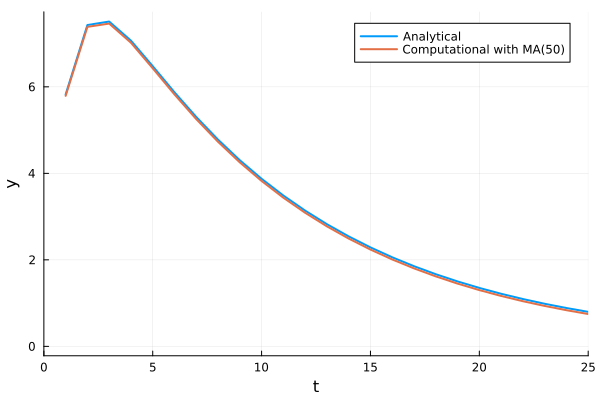

In [13]:
plot(
    [h_y_true, h_y],
    label = ["Analytical" "Computational with MA(50)"],
    ylabel = "y",
    xlabel = "t",
    legend = :topright,
    linewidth=2,
    xlims = (0,T_plot)
)